**FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS**

In [6]:
# Data Manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Time Series Models
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [7]:
# Load the datasets
df = pd.read_csv('exchange_rate.csv')

In [8]:
# Display the first few rows of the DataFrame
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [9]:
df.shape

(7588, 2)

In [10]:
df.columns

Index(['date', 'Ex_rate'], dtype='object')

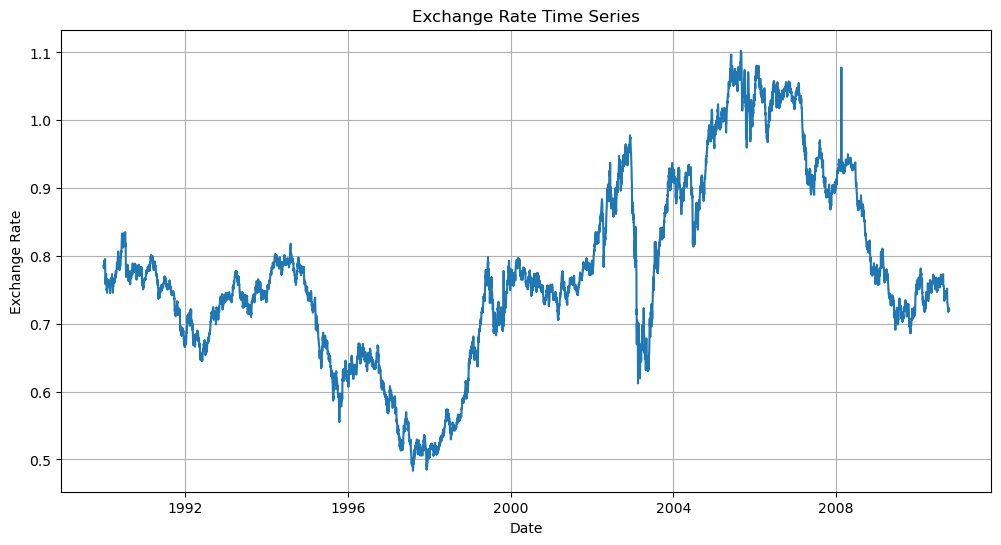

In [11]:
# Convert the 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')

# Set 'date' as the index
df.set_index('date', inplace=True)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'])
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Time Series')
plt.grid(True)
plt.show()


In [12]:
# Check for missing values
print(df.isnull().sum())

Ex_rate    0
dtype: int64


In [13]:
# Drop rows with missing values:
df_dropped = df.dropna()

In [14]:
# Fill missing values with a specific value (e.g., mean):
df_filled = df.fillna(df.mean())

In [15]:
# Interpolate missing values:
df_interpolated = df.interpolate()

In [16]:
from scipy import stats
df['z_score'] = stats.zscore(df['Ex_rate'])
df_no_outliers = df[abs(df['z_score']) < 3]
# Remove potential outliers beyond 3 standard deviations

In [17]:
df

,Ex_rate,z_score
date,,
1990-01-01,0.785500,0.062413
1990-01-02,0.781800,0.035329
1990-01-03,0.786700,0.071197
1990-01-04,0.786000,0.066073
1990-01-05,0.784900,0.058021
...,...,...
2010-10-06,0.718494,-0.428073
2010-10-07,0.721839,-0.403587
2010-10-08,0.723197,-0.393647


## Part 2: Model Building - ARIMA

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

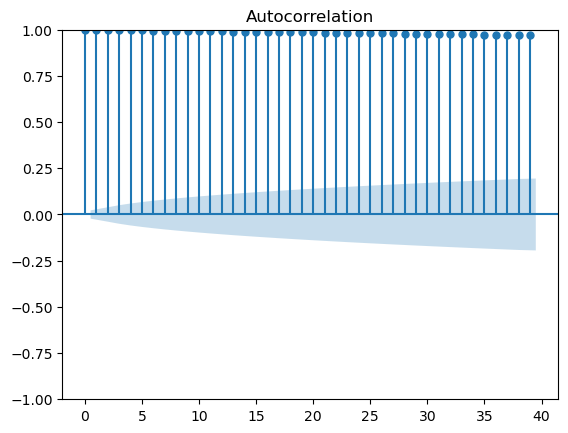

In [19]:
# Plot ACF
plot_acf(df['Ex_rate'])
plt.show()

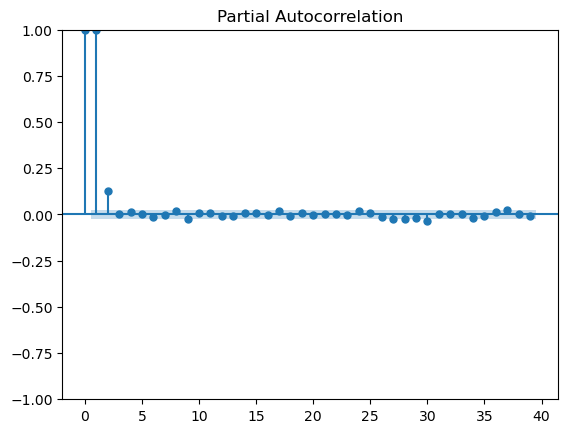

In [20]:
# Plot PACF
plot_pacf(df['Ex_rate'])
plt.show()

In [21]:
from statsmodels.tsa.arima.model import ARIMA
p = 1
d = 1
q = 1

# Fit the ARIMA model
model = ARIMA(df['Ex_rate'], order=(p, d, q))  # Replace p, d, q with actual values
es_result = model.fit()
print(es_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sat, 07 Dec 2024   AIC                         -56102.322
Time:                        10:10:40   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

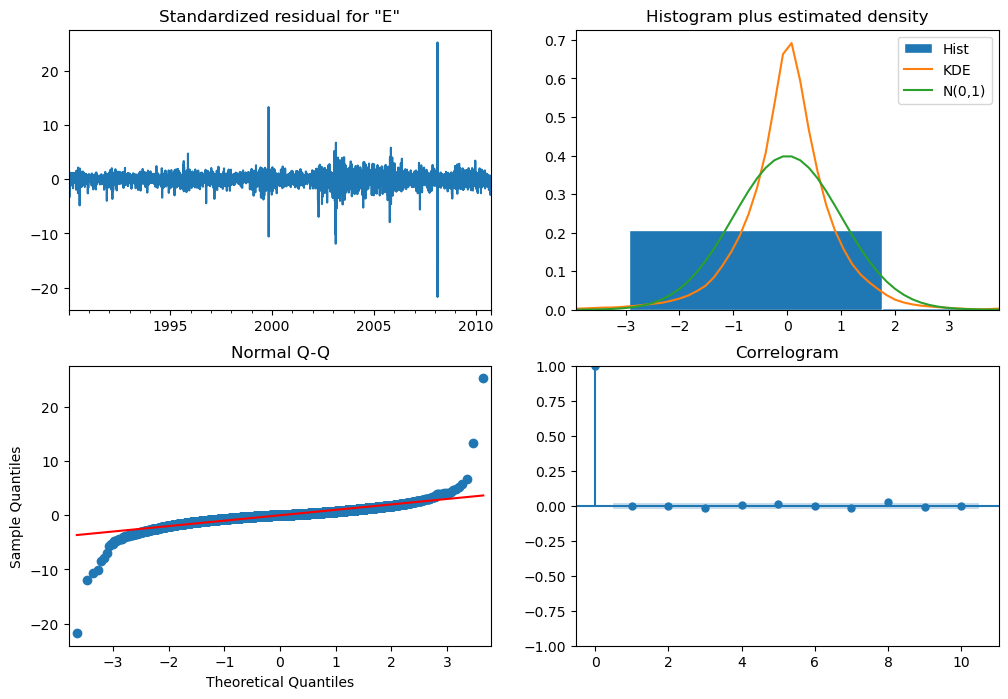

In [22]:
# Plot the residuals
es_result.plot_diagnostics(figsize=(12, 8))
plt.show()


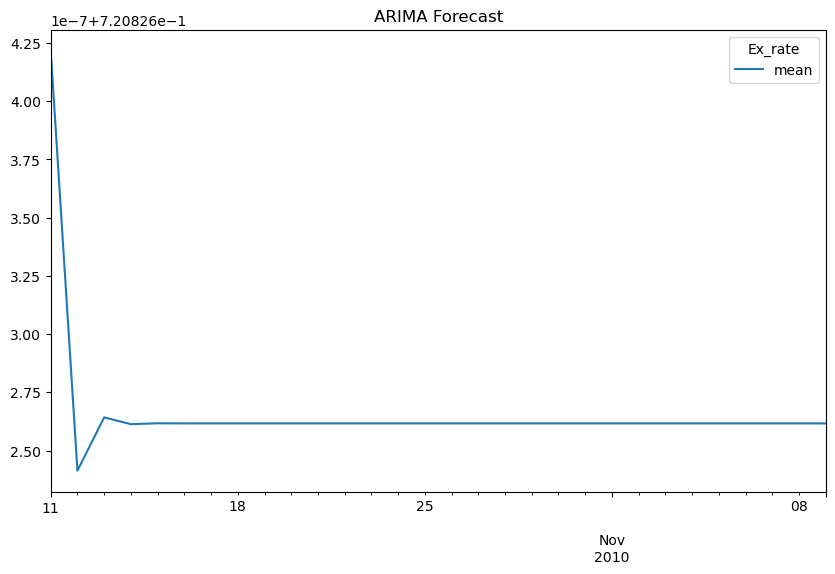

In [23]:
# Forecasting with ARIMA
forecast_arima = es_result.get_forecast(steps=30)
forecast_arima_df = forecast_arima.summary_frame()
forecast_arima_df[['mean']].plot(title='ARIMA Forecast', figsize=(10, 6))
plt.show()

##  Model Building - Exponential Smoothing

1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).

2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.

3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.


In [24]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

# Assuming the time series is non-seasonal and has no trend, we use Simple Exponential Smoothing
model = SimpleExpSmoothing(df['Ex_rate'])

# Fit the model
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:             SimpleExpSmoothing   SSE                              0.273
Optimized:                       True   AIC                         -77644.968
Trend:                           None   BIC                         -77631.099
Seasonal:                        None   AICC                        -77644.963
Seasonal Periods:                None   Date:                 Sat, 07 Dec 2024
Box-Cox:                        False   Time:                         10:10:46
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8683721                alpha                 True
initial_level              0.7855000                

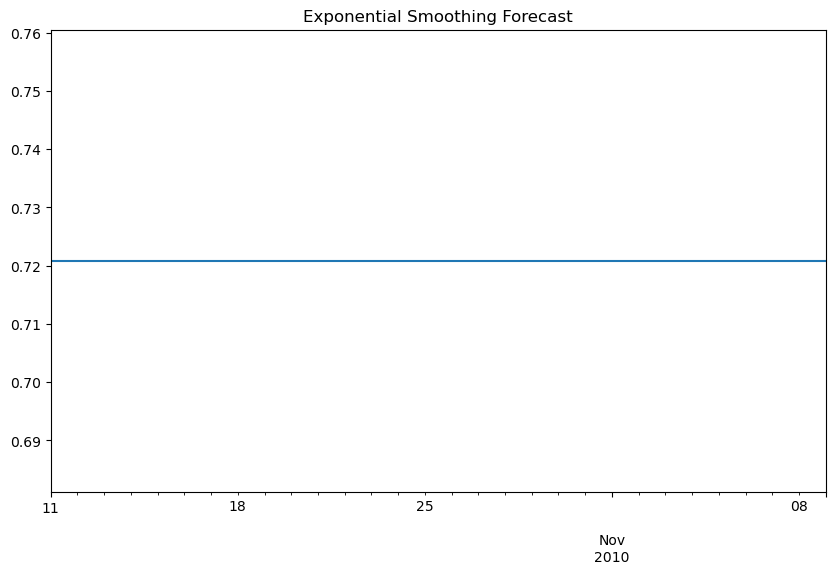

In [25]:
forecast_es = model_fit.forecast(steps=30)
forecast_es.plot(title='Exponential Smoothing Forecast', figsize=(10, 6))
plt.show()

In [26]:
# Define a grid of hyperparameters to search
params_grid = {'smoothing_level': np.arange(0.1, 1.0, 0.1)}

# Perform grid search
best_aic = float('inf')
best_params = None
for smoothing_level in params_grid['smoothing_level']:
  model = SimpleExpSmoothing(df['Ex_rate'], initialization_method="heuristic")
  model_fit = model.fit(smoothing_level=smoothing_level)
  aic = model_fit.aic
  if aic < best_aic:
    best_aic = aic
    best_params = {'smoothing_level': smoothing_level}

print("Best AIC:", best_aic)
print("Best Parameters:", best_params)

Best AIC: -77637.65809642129
Best Parameters: {'smoothing_level': 0.9}


##  Evaluation and Comparison

1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.

2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.

3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.


In [27]:
actual = df['Ex_rate'][-30:]  # Replace with actual test set
mae_arima = mean_absolute_error(actual, forecast_arima_df['mean'])
rmse_arima = np.sqrt(mean_squared_error(actual, forecast_arima_df['mean']))

mae_es = mean_absolute_error(actual, forecast_es)
rmse_es = np.sqrt(mean_squared_error(actual, forecast_es))
print(f'ARIMA' )
print(f'MAE: {mae_arima}')
print(f'RMSE: {rmse_arima}')
print('\n')
print(f'Exponential Smoothing ')
print(f'MAE: {mae_es} ')
print(f'RMSE: {rmse_es}')


ARIMA
MAE: 0.012724006489318252
RMSE: 0.016982710912774826


Exponential Smoothing 
MAE: 0.012707329121023495 
RMSE: 0.016957663728794713



> Based on the observed results and error metrics (MAE and RMSE), you would compare the performance of ARIMA and Exponential Smoothing

> **ARIMA:** Better at capturing the overall trend and minimizing large errors (due to lower RMSE), but might have more frequent small errors (due to slightly higher MAE). Suitable if minimizing large deviations is crucial.

> **Exponential Smoothing:** More consistent in minimizing small errors (lower MAE), but might be less accurate in capturing large fluctuations (higher RMSE). Suitable if overall stability of predictions is preferred.

**Advantages and Limitations:**
Advantages

ARIMA : Can capture complex patterns (trend, seasonality, autocorrelations).

Exponential Smoothing: Simple to implement and computationally efficient

Limitations

ARIMA: Requires careful parameter selection (p, d, q) and might overfit to noise

Exponential Smoothing: Less flexible for complex patterns compared to ARIMA.

> ARIM is better than Exponential Smoothing in this case